<a href="https://colab.research.google.com/github/uzair011/CN6022/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Lab CN6022: Analyzing NYC Taxi Trip Data with PySpark**

**Objective**: In this lab, you will use PySpark to perform exploratory data analysis (EDA) on the NYC Taxi Trip Duration dataset. We will load the dataset, clean it, and calculate statistical metrics such as mean, median, skewness, and kurtosis. Additionally, we'll create visualizations to better understand trip duration distributions.

**Instructions**
Run each cell in sequence to ensure proper data flow.
Review each code block and try to understand the logic behind each calculation and visualization.
Answer any questions provided at the end of this notebook to reinforce your learning.


**Required Libraries** Ensure you have the following libraries available:

PySpark for distributed data processing
Matplotlib and Seaborn for data visualization

In [1]:
#Installing pyspark
!pip install pyspark

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, stddev, skewness, kurtosis, expr, percentile_approx
from pyspark.sql.types import StringType, IntegerType, StructType, StructField, TimestampType, DoubleType

# Initialize Spark session
spark = SparkSession.builder \
    .appName("NYC_Taxi_Trip_Analysis") \
    .getOrCreate()


In [3]:
# Import some libraries
import matplotlib.pyplot as plt
import seaborn as sns


# Set visual style for matplotlib
sns.set(style="whitegrid")


In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("microize/newyork-yellow-taxi-trip-data-2020-2019")

print("Path to dataset files:", path)

100%|██████████| 1.81G/1.81G [00:31<00:00, 61.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/microize/newyork-yellow-taxi-trip-data-2020-2019/versions/25


In [6]:


# File path (replace with your CSV file URL or local path)
# 1- download from here "https://uelac-my.sharepoint.com/:x:/g/personal/mghazanfar_uel_ac_uk/EX_F5nFmIllIlADTPu90Xx4BRFK6Cbg2taitFsteIZ99fA?e=D3A2SF"
# give path from your local directory (after download)

# Read CSV file
#file_path ='/content/yellow_tripdata_2020-05.csv'
df = spark.read.csv(path, header=True, inferSchema=True)

# Show the DataFrame
df.show()


# Note, data is alos availabe here:  https://www.kaggle.com/datasets/microize/newyork-yellow-taxi-trip-data-2020-2019?select=yellow_tripdata_2020-05.csv

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|       1| 2019-04-01 00:04:09|  2019-04-01 00:06:35|              1|          0.5|         1|                 N|         239|         239|           1|        4.0|  3.0|    0.5|       1.0|         0.0|                  0.3

In [ ]:
# prompt: use the above dataframe (df) to  do this, ... Step 2 (Imputation): Correctly fills missing values using the mean. and explain the code

from pyspark.sql.functions import mean as _mean

# Calculate the mean of each numerical column
means = df.agg(*[_mean(col(c)).alias(c) for c in df.columns if df.schema[c].dataType in [IntegerType, DoubleType]])

# Fill missing values using the calculated means
df_imputed = df.na.fill(means.first().asDict())

# Show the dataframe after imputing missing values
df_imputed.show()

**Pre-Processing**

Step 1 (Original Data): Displays the initial numeric columns to give students an idea of the raw data structure.
Step 2 (Imputation): Correctly fills missing values using the mean.
Step 3 (Standardization): Combines the imputed columns and applies standardization, yielding zero-mean, unit-variance values for each feature. This is useful for features that are not on similar scales.
Step 4 (Normalization): Performs column-wise Min-Max scaling, individually normalizing each feature to the range
[
0
,
1
]
[0,1].


In [ ]:
# Pre processing

from pyspark.ml.feature import Imputer, StandardScaler, MinMaxScaler, VectorAssembler

# Define the columns to process
num_columns = ["trip_distance", "fare_amount", "tip_amount", "total_amount"]

# Step 1: Original Data
print("Original Data:")
df.select(num_columns).show(5, truncate=False)

# Step 2: Imputation - Fill missing values
imputer = Imputer(inputCols=num_columns, outputCols=[f"{col}_imputed" for col in num_columns]).setStrategy("mean")
df_imputed = imputer.fit(df).transform(df)

print("After Imputation:")
df_imputed.select([f"{col}_imputed" for col in num_columns]).show(5, truncate=False)

# Step 3: Standardization (using all imputed columns together)
assembler = VectorAssembler(inputCols=[f"{col}_imputed" for col in num_columns], outputCol="features")
df_assembled = assembler.transform(df_imputed)
scaler_standard = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
df_standard_scaled = scaler_standard.fit(df_assembled).transform(df_assembled)

print("After Standardization:")
df_standard_scaled.select("scaled_features").show(5, truncate=False)

# Step 4: Column-wise Normalization
df_minmax_scaled = df_imputed  # Start with imputed DataFrame
for col_name in num_columns:
    assembler = VectorAssembler(inputCols=[f"{col_name}_imputed"], outputCol=f"{col_name}_vector")
    df_vector = assembler.transform(df_minmax_scaled)
    min_max_scaler = MinMaxScaler(inputCol=f"{col_name}_vector", outputCol=f"{col_name}_normalized")
    df_minmax_scaled = min_max_scaler.fit(df_vector).transform(df_vector).drop(f"{col_name}_vector")

print("After Min-Max Normalization:")
df_minmax_scaled.select([f"{col}_normalized" for col in num_columns]).show(5, truncate=False)



Original Data:
+-------------+-----------+----------+------------+
|trip_distance|fare_amount|tip_amount|total_amount|
+-------------+-----------+----------+------------+
|0.5          |4.0        |1.0       |8.8         |
|0.7          |4.5        |0.0       |8.3         |
|10.9         |36.0       |7.95      |47.75       |
|0.2          |3.5        |0.0       |7.3         |
|4.8          |15.5       |3.85      |23.15       |
+-------------+-----------+----------+------------+
only showing top 5 rows

After Imputation:
+---------------------+-------------------+------------------+--------------------+
|trip_distance_imputed|fare_amount_imputed|tip_amount_imputed|total_amount_imputed|
+---------------------+-------------------+------------------+--------------------+
|0.5                  |4.0                |1.0               |8.8                 |
|0.7                  |4.5                |0.0               |8.3                 |
|10.9                 |36.0               |7.95       

In [ ]:
import pandas as pd

stats_results = {}

df_cleaned = df_imputed # we usually want to see these measures over original data

for col_name in num_columns:
    stats_results[col_name] = {
        "mean": df_cleaned.select(mean(col(col_name))).first()[0],
        "median": df_cleaned.select(percentile_approx(col(col_name), 0.5)).first(),
        "stddev": df_cleaned.select(stddev(col(col_name))).first()[0],
        "kurtosis": df_cleaned.select(kurtosis(col(col_name))).first()[0],
        "skewness": df_cleaned.select(skewness(col(col_name))).first()[0],
    }

# We can also Convert results to Pandas for easier visualization (take this as your lab assignment, use some charts, graphs to show)
stats_df = pd.DataFrame(stats_results).T
print(stats_df)

# Now see the next block for visualsaition (try it yourself before checking provided code)

                    mean   median      stddev       kurtosis    skewness
trip_distance   8.333688  (1.99,)  774.866832   75234.814308  245.133513
fare_amount     14.94219   (9.0,)  727.787407  348110.864224  589.902908
tip_amount      1.427909  (0.01,)    2.509379    4956.082071   36.535931
total_amount   19.674624  (13.8,)  727.919276  348055.692015  589.832807


                    mean   median      stddev       kurtosis    skewness
trip_distance   8.333688  (1.99,)  774.866832   75234.814308  245.133513
fare_amount     14.94219   (9.0,)  727.787407  348110.864224  589.902908
tip_amount      1.427909  (0.01,)    2.509379    4956.082071   36.535931
total_amount   19.674624  (13.8,)  727.919276  348055.692015  589.832807


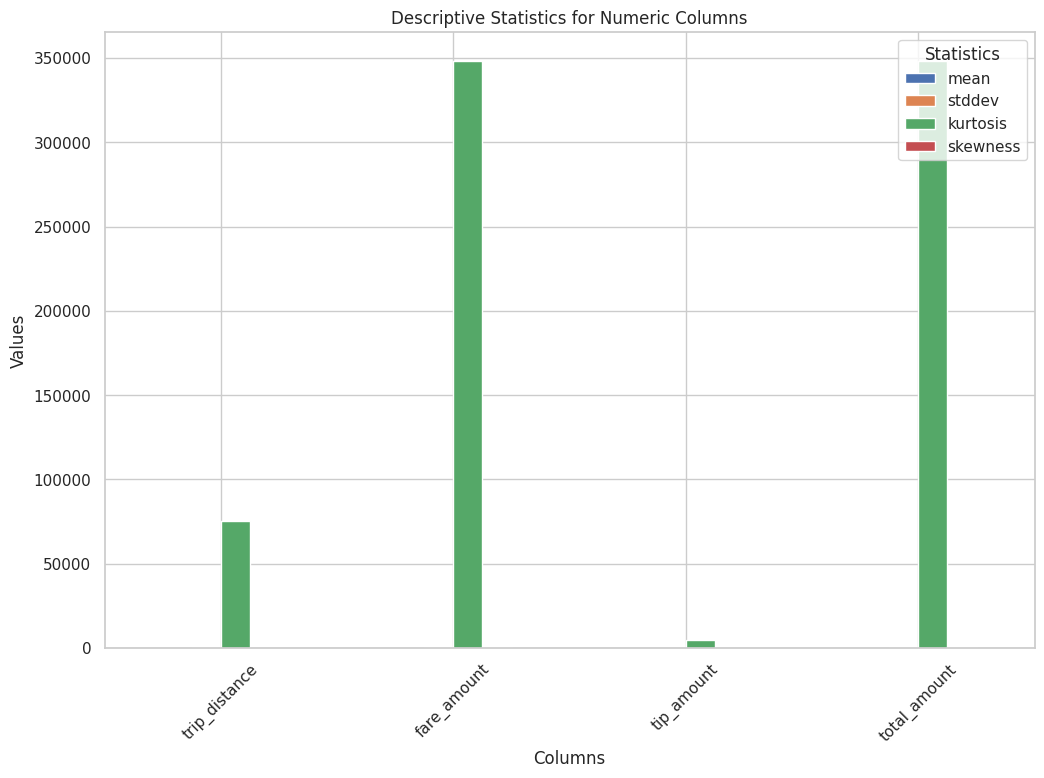

In [ ]:

# Visualize each statistic across columns
stats_df.plot(kind='bar', figsize=(12, 8))
plt.title("Descriptive Statistics for Numeric Columns")
plt.xlabel("Columns")
plt.ylabel("Values")
plt.xticks(rotation=45)
plt.legend(title="Statistics", loc='upper right')
plt.show()

# Note -- it is a rough code to show results

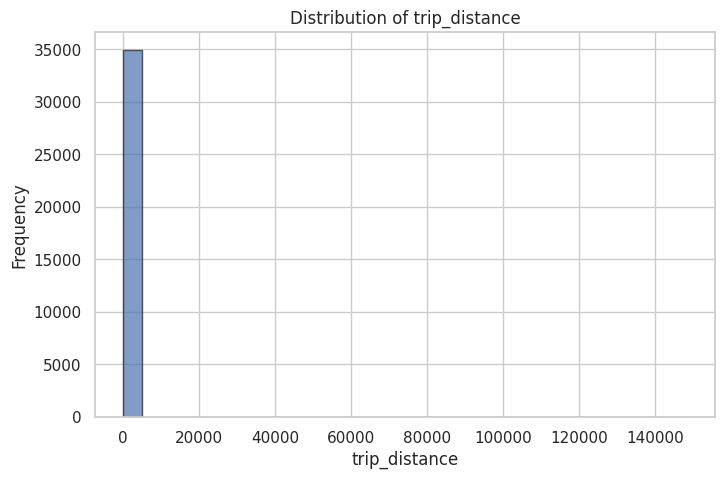

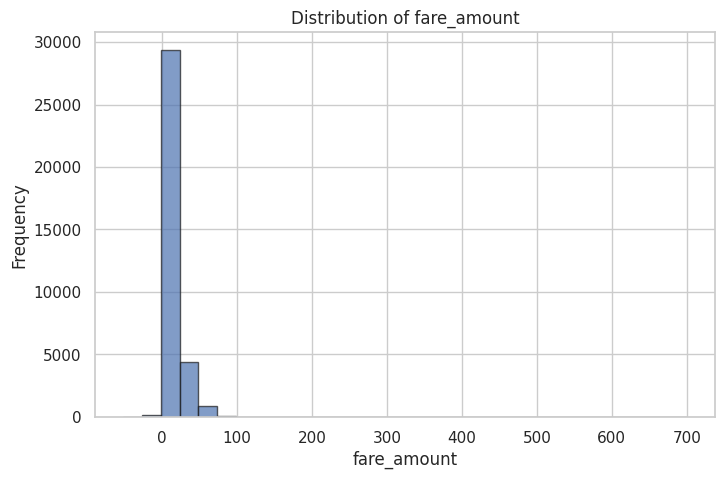

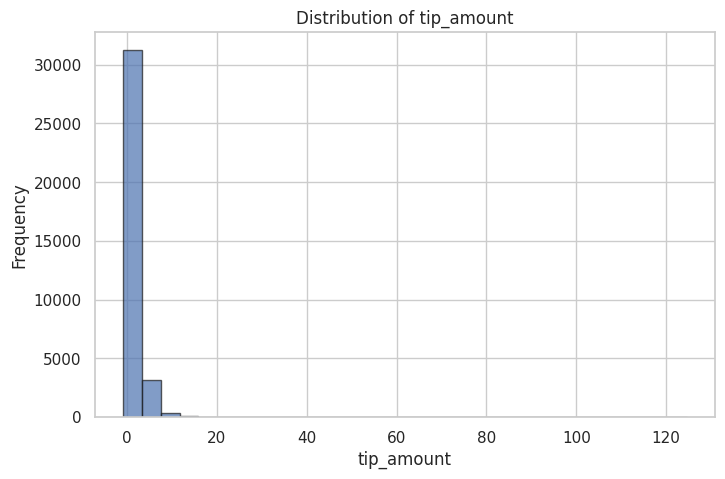

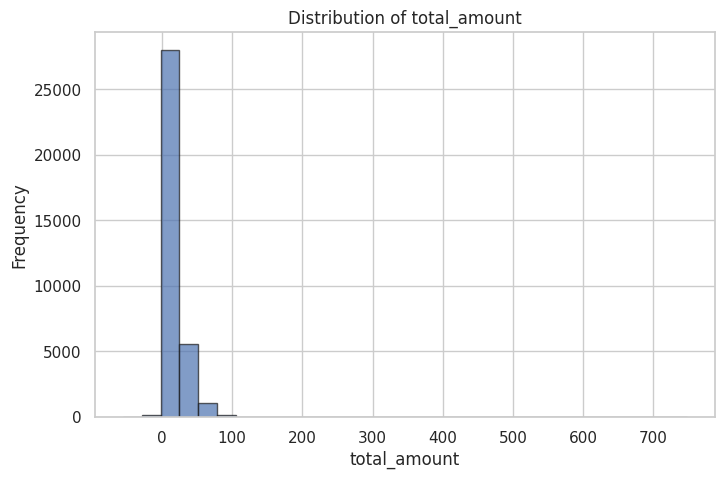

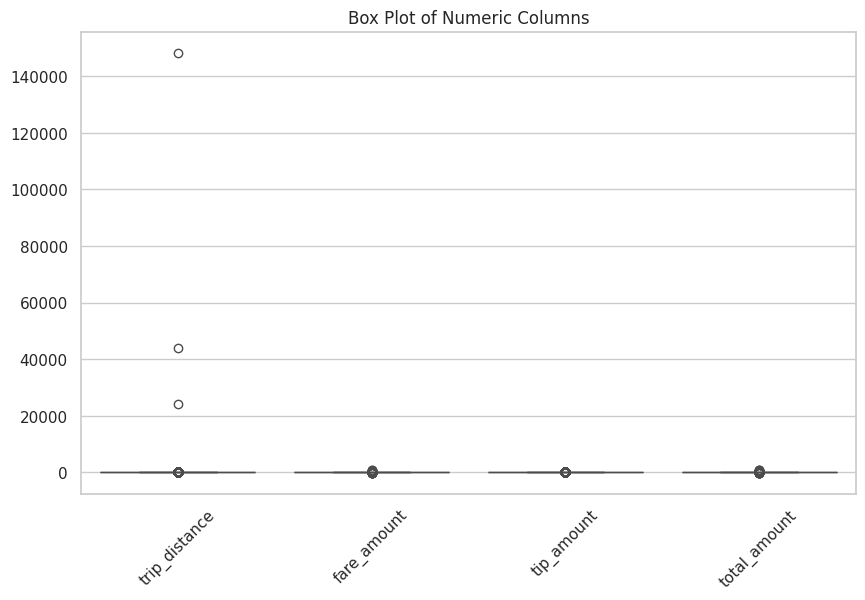

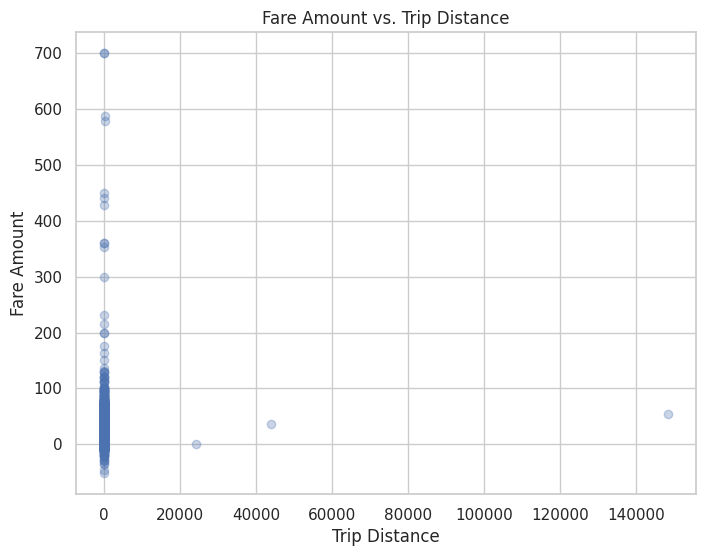

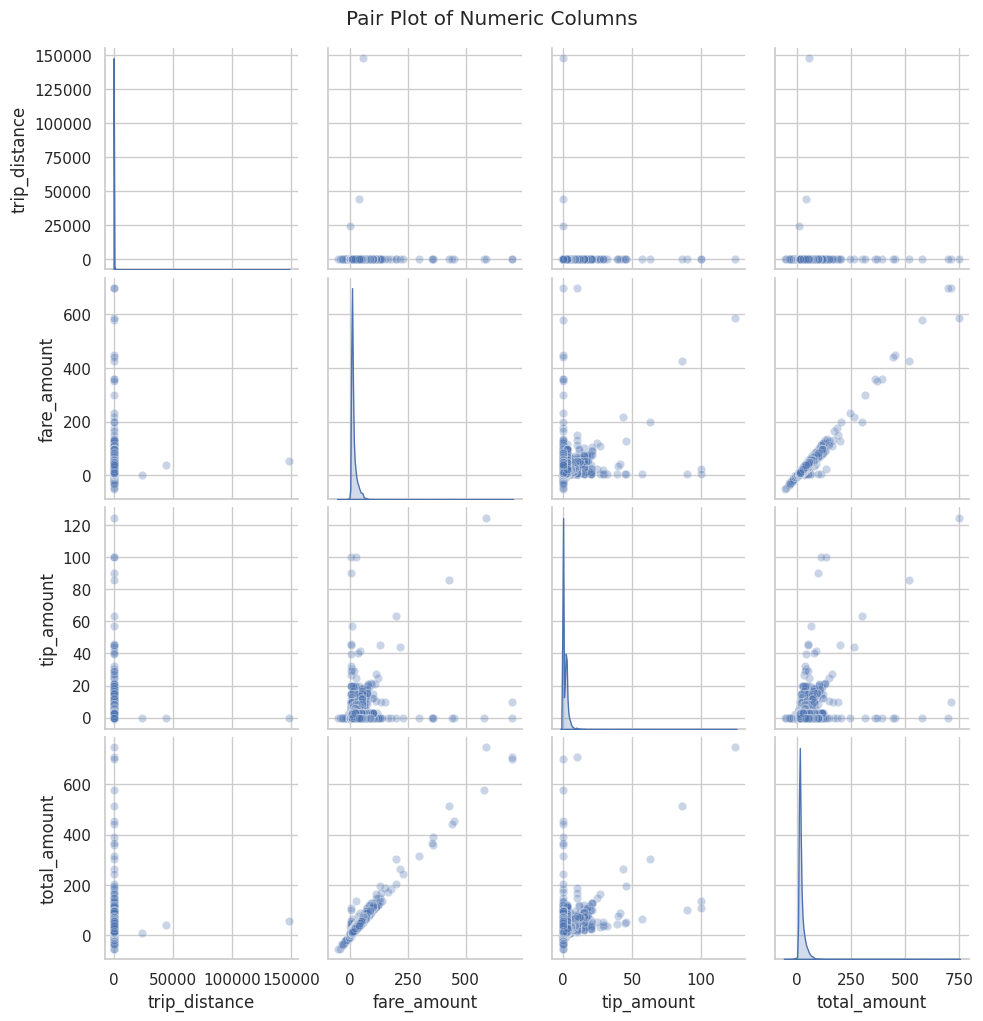

In [ ]:
# Further Analysis

# Select numeric columns to work with (use any other as you like, ask you lab tutor)
num_columns = ["trip_distance", "fare_amount", "tip_amount", "total_amount"]

# Sample data to convert to Pandas for Matplotlib & Seaborn visualizations
pandas_df = df_cleaned.select(num_columns).sample(fraction=0.1).toPandas()  # 10% sample for manageable size

# 1. Histograms for Distribution Analysis
for col_name in num_columns:
    plt.figure(figsize=(8, 5))
    plt.hist(pandas_df[col_name].dropna(), bins=30, edgecolor='k', alpha=0.7)
    plt.title(f"Distribution of {col_name}")
    plt.xlabel(col_name)
    plt.ylabel("Frequency")
    plt.show()

# 2. Box Plots to Detect Outliers
plt.figure(figsize=(10, 6))
sns.boxplot(data=pandas_df[num_columns])
plt.title("Box Plot of Numeric Columns")
plt.xticks(rotation=45)
plt.show()

# 3. Scatter Plot (Example: Fare Amount vs. Trip Distance)
plt.figure(figsize=(8, 6))
plt.scatter(pandas_df["trip_distance"], pandas_df["fare_amount"], alpha=0.3)
plt.title("Fare Amount vs. Trip Distance")
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.show()

# 4. Pair Plot for Correlations and Relationships
sns.pairplot(pandas_df[num_columns], diag_kind="kde", plot_kws={"alpha": 0.3})
plt.suptitle("Pair Plot of Numeric Columns", y=1.02)
plt.show()


**Additional Optional Challenges**

**Select Additional Columns**:
Choose other numeric columns that may have interesting patterns, such as passenger_count, tolls_amount, or congestion_surcharge.
Instruction: "Select two or three other numeric columns for analysis. Look for columns that could have meaningful relationships with each other or with the current columns."

**Perform Preprocessing and EDA**:

Follow the same steps: handle missing values, standardize, and normalize the chosen columns.
Calculate statistics (mean, median, standard deviation, kurtosis, skewness) and visualize.
Instruction: "Run the same preprocessing and statistical analysis steps on your new columns, and observe if they show similar characteristics to the current columns."
